In [1]:
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cosine
from unidecode import unidecode
from sklearn.tree import plot_tree

# Gráficos
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud

# Preprocesado y modelado
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score


# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


rt_reviews = "Depression_Text.xlsx"
df = pd.read_excel(rt_reviews)
print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Estudiante\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Estudiante\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Estudiante\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  label   Age  Gender  \
0                               let Gather For Party    0.0  16.0    Male   
1    I hate being alive when I feel so dead inside.     1.0  17.0  Female   
2  Exam are Comimg I  m already  Feeling Very Dep...    1.0  16.0    Male   
3                                       Nice picture    0.0  16.0    Male   
4  Feeling worried, even though you actually have...    1.0  16.0    Male   

  Age Category  
0     Teen Age  
1     Teen Age  
2     Teen Age  
3     Teen Age  
4     Teen Age  


In [2]:
df[['text','label']].head()

,text,label
0,let Gather For Party,0.0
1,I hate being alive when I feel so dead inside.,1.0
2,Exam are Comimg I m already Feeling Very Dep...,1.0
3,Nice picture,0.0
4,"Feeling worried, even though you actually have...",1.0


In [3]:
total_filas = df.shape[0]

print("Total de filas:", total_filas)

Total de filas: 7489


In [4]:
df.dropna(subset=["label"], inplace=True)
total_filas = df.shape[0]
print("Total de filas:", total_filas)

Total de filas: 7486


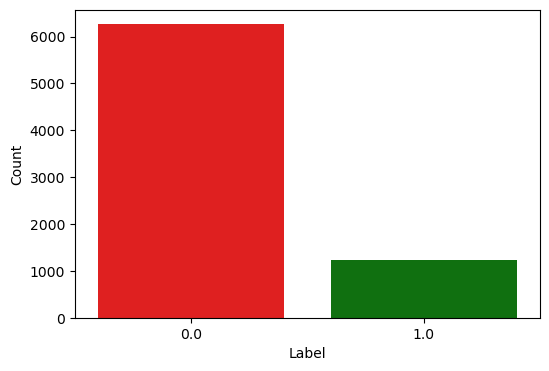

In [8]:
# Establecer el tamaño de la figura
plt.figure(figsize=(6, 4))

# Crear un countplot con las categorías "rotten" y "freshness" de diferentes colores
sns.countplot(data=df, x='label', palette={0: 'red', 1: 'green'})

# Configurar los ejes y etiquetas
plt.xlabel('Label')
plt.ylabel('Count')

# Mostrar el gráfico
plt.show()

In [9]:
def remove_pos(tokens):
    # Obtener la lista de stopwords (incluye preposiciones) en inglés
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    pronouns = set()
    tagged_words = pos_tag(stopwords)
    for word, tag in tagged_words:
        if tag.startswith('PRP'):
            pronouns.add(word)
    
    tagged_tokens = pos_tag(tokens)
    tokens_without_pos = [token[0] for token in tagged_tokens if token[0] not in stopwords and token[0] not in pronouns]
    
    return tokens_without_pos

In [21]:
def limpiar_tokenizar(texto, remove_pos):
    # Crear instancia del lematizador

    lemmatizer = WordNetLemmatizer()
    nuevo_texto = str(texto).lower() if texto else ""
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de diéresis
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de fracciones
    nuevo_texto = re.sub("\d+/\d+", ' ', nuevo_texto)
    # Eliminación de fechas
    nuevo_texto = re.sub("\d{1,2}/\d{1,2}/\d{2,4}", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Eliminar preposiciones, pronombres y stopWords
    nuevo_texto = remove_pos(nuevo_texto)
    # Lematización
    nuevo_texto = [lemmatizer.lemmatize(token) for token in nuevo_texto]
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return nuevo_texto

In [22]:
df['texto_tokenizado'] = df['text'].apply(lambda x: limpiar_tokenizar(x, remove_pos))


In [24]:

df[['label','text','texto_tokenizado']].to_csv('resultadoTokeniz.csv', index=False)

In [25]:
texto_tidy =df.explode(column='texto_tokenizado')
texto_tidy= texto_tidy.drop(columns='text')
texto_tidy= texto_tidy.rename(columns={'texto_tokenizado':'token'})
texto_tidy.head(10)

,label,Age,Gender,Age Category,token
0,0.0,16.0,Male,Teen Age,let
0,0.0,16.0,Male,Teen Age,gather
0,0.0,16.0,Male,Teen Age,party
1,1.0,17.0,Female,Teen Age,hate
1,1.0,17.0,Female,Teen Age,alive
1,1.0,17.0,Female,Teen Age,feel
1,1.0,17.0,Female,Teen Age,dead
1,1.0,17.0,Female,Teen Age,inside
2,1.0,16.0,Male,Teen Age,exam
2,1.0,16.0,Male,Teen Age,comimg


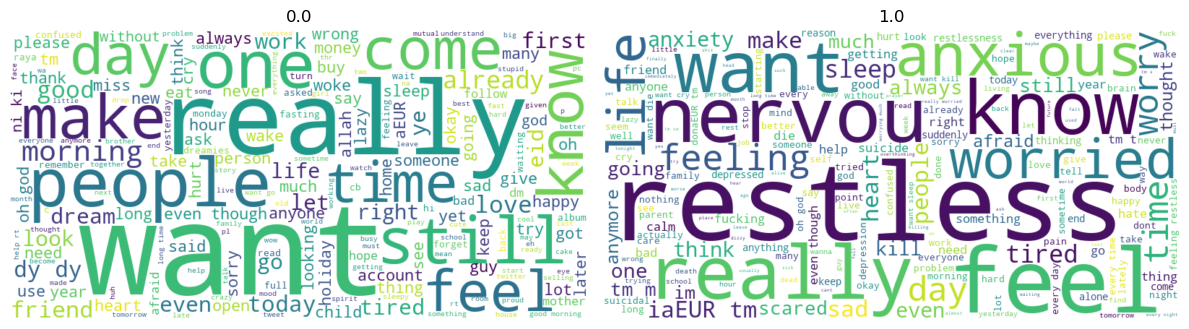

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert float items to strings in the palabras list
palabras_por_categoria = texto_tidy.groupby('label')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordclouds = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))
    wordclouds[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(12, 6))
for i, (categoria, wordcloud) in enumerate(wordclouds.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

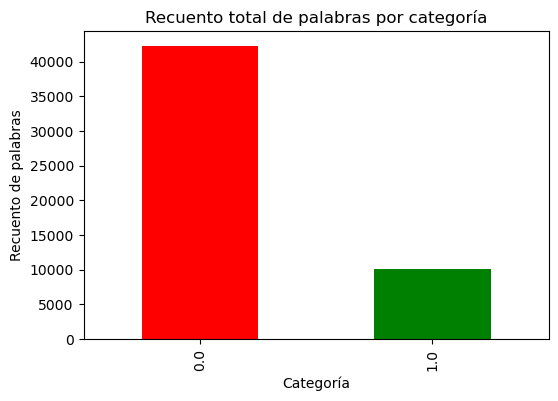

--------------------------
Palabras totales por categoría 👇
--------------------------


label
0.0    42305
1.0    10105
Name: token, dtype: int64

In [27]:
#@title Recuento total de palabras por categoría
word_count = texto_tidy.groupby('label')['token'].count()

# Crear la tabla gráfica
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['red', 'green']  # Colores para las categorías 'rotten' y 'fresh'
word_count.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('Categoría')
ax.set_ylabel('Recuento de palabras')
ax.set_title('Recuento total de palabras por categoría')

# Mostrar la tabla gráfica
plt.show()

print('--------------------------')
print('Palabras totales por categoría 👇')
print('--------------------------')
texto_tidy.groupby(by='label')['token'].count()

In [28]:
print('----------------------------')
print('Palabras distintas por categoria')
print('----------------------------')
texto_tidy.groupby(by='label')['token'].nunique()

----------------------------
Palabras distintas por categoria
----------------------------


label
0.0    10419
1.0     2234
Name: token, dtype: int64

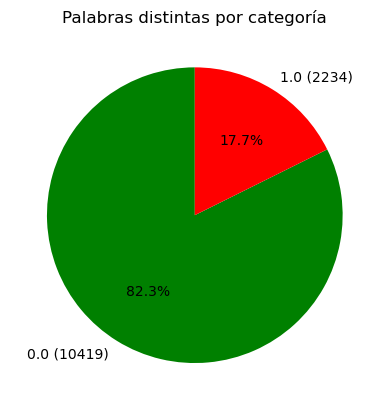

In [29]:
#@title Gráfico porcentaje de palabras distintas por categoría
unique_words = texto_tidy.groupby('label')['token'].nunique()

# Definir los colores de las categorías
colors = ['green', 'red']

# Crear el gráfico de pastel
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(unique_words, labels=unique_words.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Agregar los valores numéricos junto a las etiquetas
for i, label in enumerate(texts):
    percentage = label.get_text()
    count = unique_words[i]
    label.set_text(f'{percentage} ({count})')

ax.set_title('Palabras distintas por categoría')

# Mostrar el gráfico de pastel
plt.show()

In [34]:
palabras_depressed = set(texto_tidy[texto_tidy.label == 1]['token'])
palabras_notdepressed = set(texto_tidy[texto_tidy.label == 0]['token'])


print(f"Palabras comunes entre 0 y 1: {len(palabras_depressed.intersection(palabras_notdepressed))}")

Palabras comunes entre 0 y 1: 1450


In [35]:
palabras_comunes = palabras_depressed.intersection(palabras_notdepressed)
palabras_comunes_lista = list(palabras_comunes)

df_palabras_comunes = pd.DataFrame(palabras_comunes_lista, columns=['Palabra'])
df_palabras_comunes.to_csv('palabras_comunes.csv', index=False)

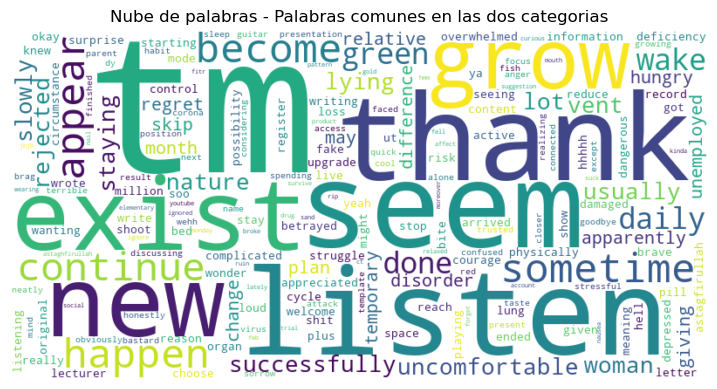

In [36]:
palabras_comunes_str = [str(palabra) for palabra in palabras_comunes]

# Crear una cadena de texto con las palabras comunes
texto_comun = ' '.join(palabras_comunes_str)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comun)

# Mostrar la nube de palabras
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Palabras comunes en las dos categorias')
plt.show()